# Magics

In [1]:
%load_ext autoreload

%autoreload 2

# Imports

In [2]:
import os
import gc
import configparser
import pathlib as p
import numpy as np
import seaborn as sns

In [3]:
import resource
rlimit = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (6000, rlimit[1]))

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt 

In [5]:
import pandas as pd
pd.options.display.max_columns = 999

In [6]:
import torch

In [7]:
import clipper_python as clipper

In [8]:
import torch.nn as nn
import torch.optim as optim

In [9]:
from frag_nn.pytorch.network import GNINA_regressor, GNINA_regressor_v2, GNINA_regressor_v3, GNINA_regressor_v4, GNINA_regressor_v5, GNINA_regressor_v6, GNINA_regressor_v7, GNINA_regressor_v8
# from frag_nn.data import XChemData
from frag_nn.pytorch.network import ClassifierV3, ClassifierV4, ClassifierV5
from frag_nn.pytorch.dataset import EventDataset
from frag_nn.pytorch.dataset import OrthogonalGrid
from frag_nn.pytorch.dataset import GetRandomisedLocation, GetRandomisedRotation, SetRoot
from frag_nn.pytorch.dataset import GetAnnotationClassifier, GetDataRefMoveZ

from frag_nn.pytorch.dataset import XChemDataset
import frag_nn.constants as c


# Get Config

In [10]:
config_path = "/home/zoh22914/pandda_nn_2/frag_nn/params.ini"

In [11]:
conf = configparser.ConfigParser()

In [12]:
conf.read(config_path)

['/home/zoh22914/pandda_nn_2/frag_nn/params.ini']

In [13]:
ds_conf = conf[c.x_chem_database]

In [14]:
grid_size = 48
grid_step = 0.5
filters = 64


In [15]:
network_type = "classifier"
network_version = 5
dataset_version = 3
train = "gpu"
transforms = "rottrans"

In [16]:
state_dict_dir = "/home/zoh22914/pandda_nn_2/"
state_dict_file = state_dict_dir + "model_params_{}_{}_{}_{}_{}_{}_{}_{}.pt".format(grid_size,
                                                                                  grid_step,
                                                                                  network_type,
                                                                                  network_version,
                                                                                  dataset_version,
                                                                                  train,
                                                                                  transforms,
                                                                                     filters)

# Get accessible events

In [17]:
events_test = pd.read_csv("new_events_test_no_cheat.csv")

/home/zoh22914/anaconda3/envs/env_ml_clipper/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [18]:
events_test

Unnamed: 0  1-BDC Comment  Interesting Ligand Confidence  Ligand Placed  \
0            155   0.16    None        False               Low          False   
1            156   0.18    None        False               Low          False   
2            157   0.19    None        False               Low          False   
3            158   0.18    None        False               Low          False   
4            159   0.18    None        False               Low          False   
...          ...    ...     ...          ...               ...            ...   
2959       26085   0.10    None        False               Low          False   
2960       26086   0.13    None        False               Low          False   
2961       26087   0.16    None        False               Low          False   
2962       26088   0.15    None        False               Low          False   
2963       26089   0.18    None        False               Low          False   

      Viewed  analysed  analysed_resolution  applied_b_factor_scaling  \
0       True     False                 1.34                    -0.438   
1       True     False                 1.74                    -2.022   
2       True     False                 1.79                    -1.783   
3       True     False                 1.39                    -0.742   
4       True     False                 1.44                    -1.433   
...      ...       ...                  ...                       ...   
2959    True      True                 2.53                    -1.338   
2960    True      True                 2.93                    -5.485   
2961    True      True                 2.53                    -1.123   
2962    True      True                 2.53                    -2.976   
2963    True      True                 2.53                    -2.976   

      cluster_size          dtag  event_idx  exclude_from_characterisation  \
0             1335  ATAD2A-x1488          1                          False   
1             1075  ATAD2A-x1487          1                          False   
2              983  ATAD2A-x1489          1                          False   
3              946  ATAD2A-x1486          1                          False   
4              430  ATAD2A-x1690          4                          False   
...            ...           ...        ...                            ...   
2959           603    PDK2-x0166          3                          False   
2960           221    PDK2-x0020          1                          False   
2961           128    PDK2-x0169          3                          False   
2962           114    PDK2-x0007          3                          False   
2963           282    PDK2-x0007          4                          False   

     exclude_from_z_map_analysis exclude_from_zmap_analysis  \
0                            NaN                      False   
1                            NaN                      False   
2                            NaN                      False   
3                            NaN                      False   
4                            NaN                      False   
...                          ...                        ...   
2959                         NaN                      False   
2960                         NaN                      False   
2961                         NaN                      False   
2962                         NaN                      False   
2963                         NaN                      False   

      global_correlation_to_average_map  global_correlation_to_mean_map  \
0                                   NaN                        0.811992   
1                                   NaN                        0.770571   
2                                   NaN                        0.765815   
3                                   NaN                        0.763977   
4                                   NaN                        0.811292   
...         

# Create Dataset

In [19]:
grid = OrthogonalGrid(grid_size, 
                     grid_step)

In [20]:
test_dataset = EventDataset(events=events_test,
                             transforms_record=[GetRandomisedLocation(base_trans_max=4.0, secondary_trans_max=0.0),
                                                    GetRandomisedRotation(max_rot=0.0),
                                                    SetRoot("/data/data")
                                               ],
                             get_annotation=GetAnnotationClassifier(),
                             get_data=GetDataRefMoveZ(grid)
                            )

# Create Dataloaders

In [21]:
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                         batch_size=1, 
                                         shuffle=True,
                                         num_workers=48)

# Define Model

In [22]:
model = ClassifierV5(filters,
                        grid_dimension=grid_size)

In [23]:
model.load_state_dict(torch.load(state_dict_file))

In [24]:
model_c = model.to("cuda:1")

# Precision - Recall functions

In [25]:
def get_precision(y_hat, y, cutoff):
    
    positives_hat_mask = (y_hat > cutoff)
    negatives_hat_mask = (y_hat <= cutoff)
    
    positives_mask = (y == 1)
    negatives_mask = (y == 0)

    true_positives = np.count_nonzero(positives_hat_mask[positives_mask])
    false_positives = np.count_nonzero(positives_hat_mask[negatives_mask])
    
    total_predicted_positives = true_positives + false_positives
    
    if total_predicted_positives == 0:
        return 1
    
    precision = true_positives / total_predicted_positives
    
    return precision


In [26]:
def get_recall(y_hat, y, cutoff):
    positives_hat_mask = (y_hat > cutoff)
    negatives_hat_mask = (y_hat <= cutoff)

    positives_mask = (y == 1)
    negatives_mask = (y == 0)

    true_positives = np.count_nonzero(positives_hat_mask[positives_mask])
    false_negatives = np.count_nonzero(negatives_hat_mask[positives_mask])    

    total_positives = (true_positives + false_negatives)
    
    if total_positives == 0:
        return 0
    
    recall = true_positives / total_positives

    return recall

# Evaluate - Test Data

In [27]:
y_test = []
y_test_hat = []

In [28]:
for i, data in enumerate(test_dataloader):
    # get the inputs; data is a list of [inputs, labels]
    print("Iteration: {}".format(i))
    x = data["data"]
    y = data["annotation"]
#     x = x.unsqueeze(1)
    y = y.view(-1,2)
    
    x_c = x.to("cuda:1")
    y_c = y.to("cuda:1")
    
    outputs_c = model_c(x_c)
    
    outputs = outputs_c.detach().to("cpu")
    print(outputs)
    y_test.append(y.detach())
    y_test_hat.append(outputs)
#     optimizer.zero_grad()


Iteration: 0


/home/zoh22914/pandda_nn_2/frag_nn/pytorch/network.py:1178: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.act(x)


tensor([[ 0.7245,  0.2755]])
Iteration: 1
tensor([[ 0.9950,  0.0050]])
Iteration: 2
tensor([[ 0.7693,  0.2307]])
Iteration: 3
tensor([[ 0.8001,  0.1999]])
Iteration: 4
tensor([[ 0.8518,  0.1482]])
Iteration: 5
tensor([[ 0.8396,  0.1604]])
Iteration: 6
tensor([[ 0.8198,  0.1802]])
Iteration: 7
tensor([[ 0.9993,  0.0007]])
Iteration: 8
tensor([[ 0.7581,  0.2419]])
Iteration: 9
tensor([[ 0.9895,  0.0105]])
Iteration: 10
tensor([[ 0.9496,  0.0504]])
Iteration: 11
tensor([[ 0.8994,  0.1006]])
Iteration: 12
tensor([[ 0.5950,  0.4050]])
Iteration: 13
tensor([[ 0.0697,  0.9303]])
Iteration: 14
tensor([[ 0.8335,  0.1665]])
Iteration: 15
tensor([[ 0.9294,  0.0706]])
Iteration: 16
tensor([[ 0.9996,  0.0004]])
Iteration: 17
tensor([[ 0.0990,  0.9010]])
Iteration: 18
tensor([[ 0.9966,  0.0034]])
Iteration: 19
tensor([[ 0.4101,  0.5899]])
Iteration: 20
tensor([[ 0.9300,  0.0700]])
Iteration: 21
tensor([[ 0.3141,  0.6859]])
Iteration: 22
tensor([[ 0.9471,  0.0529]])
Iteration: 23
tensor([[ 0.9241,  0

tensor([[ 0.5017,  0.4983]])
Iteration: 197
tensor([[ 0.9939,  0.0061]])
Iteration: 198
tensor([[ 0.5913,  0.4087]])
Iteration: 199
tensor([[ 0.9751,  0.0249]])
Iteration: 200
tensor([[ 0.8996,  0.1004]])
Iteration: 201
tensor([[ 0.5806,  0.4194]])
Iteration: 202
tensor([[ 0.4282,  0.5718]])
Iteration: 203
tensor([[ 0.9504,  0.0496]])
Iteration: 204
tensor([[ 0.9358,  0.0642]])
Iteration: 205
tensor([[ 0.9870,  0.0130]])
Iteration: 206
tensor([[ 0.9524,  0.0476]])
Iteration: 207
tensor([[ 0.9116,  0.0884]])
Iteration: 208
tensor([[ 0.9893,  0.0107]])
Iteration: 209
tensor([[ 0.9837,  0.0163]])
Iteration: 210
tensor([[ 0.8882,  0.1118]])
Iteration: 211
tensor([[ 0.9587,  0.0413]])
Iteration: 212
tensor([[ 0.9429,  0.0571]])
Iteration: 213
tensor([[ 0.8976,  0.1024]])
Iteration: 214
tensor([[ 0.9975,  0.0025]])
Iteration: 215
tensor([[ 0.3980,  0.6020]])
Iteration: 216
tensor([[ 0.8378,  0.1622]])
Iteration: 217
tensor([[ 0.2982,  0.7018]])
Iteration: 218
tensor([[ 0.9844,  0.0156]])
Ite

tensor([[ 0.9982,  0.0018]])
Iteration: 388
tensor([[ 0.2552,  0.7448]])
Iteration: 389
tensor([[ 0.8976,  0.1024]])
Iteration: 390
tensor([[ 0.9981,  0.0019]])
Iteration: 391
tensor([[ 0.7714,  0.2286]])
Iteration: 392
tensor([[ 0.9498,  0.0502]])
Iteration: 393
tensor([[ 0.1740,  0.8260]])
Iteration: 394
tensor([[ 0.8768,  0.1232]])
Iteration: 395
tensor([[ 0.9615,  0.0385]])
Iteration: 396
tensor([[ 0.7623,  0.2377]])
Iteration: 397
tensor([[ 0.6415,  0.3585]])
Iteration: 398
tensor([[ 0.3066,  0.6934]])
Iteration: 399
tensor([[ 0.9847,  0.0153]])
Iteration: 400
tensor([[ 0.9766,  0.0234]])
Iteration: 401
tensor([[ 0.9894,  0.0106]])
Iteration: 402
tensor([[ 0.8582,  0.1418]])
Iteration: 403
tensor([[ 0.5476,  0.4524]])
Iteration: 404
tensor([[ 0.1897,  0.8103]])
Iteration: 405
tensor([[ 0.9935,  0.0065]])
Iteration: 406
tensor([[ 0.9436,  0.0564]])
Iteration: 407
tensor([[ 0.9512,  0.0488]])
Iteration: 408
tensor([[ 0.9863,  0.0137]])
Iteration: 409
tensor([[ 0.9884,  0.0116]])
Ite

tensor([[ 0.5449,  0.4551]])
Iteration: 576
tensor([[ 0.4123,  0.5877]])
Iteration: 577
tensor([[ 0.1895,  0.8105]])
Iteration: 578
tensor([[ 0.9448,  0.0552]])
Iteration: 579
tensor([[ 0.9732,  0.0268]])
Iteration: 580
tensor([[ 0.3567,  0.6433]])
Iteration: 581
tensor([[ 0.9987,  0.0013]])
Iteration: 582
tensor([[ 0.7598,  0.2402]])
Iteration: 583
tensor([[ 0.9961,  0.0039]])
Iteration: 584
tensor([[ 0.9848,  0.0152]])
Iteration: 585
tensor([[ 0.9890,  0.0110]])
Iteration: 586
tensor([[ 0.6760,  0.3240]])
Iteration: 587
tensor([[ 0.7477,  0.2523]])
Iteration: 588
tensor([[ 0.4723,  0.5277]])
Iteration: 589
tensor([[ 0.9534,  0.0466]])
Iteration: 590
tensor([[ 0.4462,  0.5538]])
Iteration: 591
tensor([[ 0.5444,  0.4556]])
Iteration: 592
tensor([[ 0.9425,  0.0575]])
Iteration: 593
tensor([[ 0.7041,  0.2959]])
Iteration: 594
tensor([[ 0.8489,  0.1511]])
Iteration: 595
tensor([[ 0.9483,  0.0517]])
Iteration: 596
tensor([[ 0.8211,  0.1789]])
Iteration: 597
tensor([[ 0.7606,  0.2394]])
Ite

Iteration: 764
tensor([[ 0.7393,  0.2607]])
Iteration: 765
tensor([[ 0.3501,  0.6499]])
Iteration: 766
tensor([[ 0.9731,  0.0269]])
Iteration: 767
tensor([[ 0.5480,  0.4520]])
Iteration: 768
tensor([[ 0.8072,  0.1928]])
Iteration: 769
tensor([[ 0.4756,  0.5244]])
Iteration: 770
tensor([[ 0.9700,  0.0300]])
Iteration: 771
tensor([[ 0.8339,  0.1661]])
Iteration: 772
tensor([[ 0.9997,  0.0003]])
Iteration: 773
tensor([[ 0.9438,  0.0562]])
Iteration: 774
tensor([[ 0.8735,  0.1265]])
Iteration: 775
tensor([[ 0.8815,  0.1185]])
Iteration: 776
tensor([[ 0.7825,  0.2175]])
Iteration: 777
tensor([[ 0.9639,  0.0361]])
Iteration: 778
tensor([[ 0.8954,  0.1046]])
Iteration: 779
tensor([[ 0.2500,  0.7500]])
Iteration: 780
tensor([[ 0.4995,  0.5005]])
Iteration: 781
tensor([[ 0.8551,  0.1449]])
Iteration: 782
tensor([[ 0.6417,  0.3583]])
Iteration: 783
tensor([[ 0.9181,  0.0819]])
Iteration: 784
tensor([[ 0.9154,  0.0846]])
Iteration: 785
tensor([[ 0.8838,  0.1162]])
Iteration: 786
tensor([[ 0.9514,

tensor([[ 0.8707,  0.1293]])
Iteration: 954
tensor([[ 0.3543,  0.6457]])
Iteration: 955
tensor([[ 0.9709,  0.0291]])
Iteration: 956
tensor([[ 0.8957,  0.1043]])
Iteration: 957
tensor([[ 0.8899,  0.1101]])
Iteration: 958
tensor([[ 0.8706,  0.1294]])
Iteration: 959
tensor([[ 0.9351,  0.0649]])
Iteration: 960
tensor([[ 0.9701,  0.0299]])
Iteration: 961
tensor([[ 0.7137,  0.2863]])
Iteration: 962
tensor([[ 0.8890,  0.1110]])
Iteration: 963
tensor([[ 0.8562,  0.1438]])
Iteration: 964
tensor([[ 0.9503,  0.0497]])
Iteration: 965
tensor([[ 0.9740,  0.0260]])
Iteration: 966
tensor([[ 0.9947,  0.0053]])
Iteration: 967
tensor([[ 0.9935,  0.0065]])
Iteration: 968
tensor([[ 0.8078,  0.1922]])
Iteration: 969
tensor([[ 0.9912,  0.0088]])
Iteration: 970
tensor([[ 0.9789,  0.0211]])
Iteration: 971
tensor([[ 0.9977,  0.0023]])
Iteration: 972
tensor([[ 0.3317,  0.6683]])
Iteration: 973
tensor([[ 0.4557,  0.5443]])
Iteration: 974
tensor([[ 0.9997,  0.0003]])
Iteration: 975
tensor([[ 0.2895,  0.7105]])
Ite

tensor([[ 0.9406,  0.0594]])
Iteration: 1145
tensor([[ 0.8139,  0.1861]])
Iteration: 1146
tensor([[ 0.3407,  0.6593]])
Iteration: 1147
tensor([[ 0.8276,  0.1724]])
Iteration: 1148
tensor([[ 0.8033,  0.1967]])
Iteration: 1149
tensor([[ 0.9326,  0.0674]])
Iteration: 1150
tensor([[ 0.9677,  0.0323]])
Iteration: 1151
tensor([[ 0.9464,  0.0536]])
Iteration: 1152
tensor([[ 0.8154,  0.1846]])
Iteration: 1153
tensor([[ 0.1895,  0.8105]])
Iteration: 1154
tensor([[ 0.8946,  0.1054]])
Iteration: 1155
tensor([[ 0.5355,  0.4645]])
Iteration: 1156
tensor([[ 0.4949,  0.5051]])
Iteration: 1157
tensor([[ 0.6408,  0.3592]])
Iteration: 1158
tensor([[ 0.6686,  0.3314]])
Iteration: 1159
tensor([[ 0.1245,  0.8755]])
Iteration: 1160
tensor([[ 0.4887,  0.5113]])
Iteration: 1161
tensor([[ 0.4353,  0.5647]])
Iteration: 1162
tensor([[ 0.4116,  0.5884]])
Iteration: 1163
tensor([[ 0.3678,  0.6322]])
Iteration: 1164
tensor([[ 0.9984,  0.0016]])
Iteration: 1165
tensor([[ 0.9965,  0.0035]])
Iteration: 1166
tensor([[ 

tensor([[ 0.9940,  0.0060]])
Iteration: 1330
tensor([[ 0.8795,  0.1205]])
Iteration: 1331
tensor([[ 0.9832,  0.0168]])
Iteration: 1332
tensor([[ 0.9101,  0.0899]])
Iteration: 1333
tensor([[ 0.9955,  0.0045]])
Iteration: 1334
tensor([[ 0.9994,  0.0006]])
Iteration: 1335
tensor([[ 0.2502,  0.7498]])
Iteration: 1336
tensor([[ 0.9894,  0.0106]])
Iteration: 1337
tensor([[ 0.0932,  0.9068]])
Iteration: 1338
tensor([[ 0.6827,  0.3173]])
Iteration: 1339
tensor([[ 0.9806,  0.0194]])
Iteration: 1340
tensor([[ 0.1732,  0.8268]])
Iteration: 1341
tensor([[ 0.9740,  0.0260]])
Iteration: 1342
tensor([[ 0.9669,  0.0331]])
Iteration: 1343
tensor([[ 0.1046,  0.8954]])
Iteration: 1344
tensor([[ 0.9953,  0.0047]])
Iteration: 1345
tensor([[ 0.8147,  0.1853]])
Iteration: 1346
tensor([[ 0.0805,  0.9195]])
Iteration: 1347
tensor([[ 0.4358,  0.5642]])
Iteration: 1348
tensor([[ 0.7114,  0.2886]])
Iteration: 1349
tensor([[ 0.8792,  0.1208]])
Iteration: 1350
tensor([[ 0.8382,  0.1618]])
Iteration: 1351
tensor([[ 

Iteration: 1517
tensor([[ 0.9964,  0.0036]])
Iteration: 1518
tensor([[ 0.7892,  0.2108]])
Iteration: 1519
tensor([[ 0.8822,  0.1178]])
Iteration: 1520
tensor([[ 0.6789,  0.3211]])
Iteration: 1521
tensor([[ 0.9826,  0.0174]])
Iteration: 1522
tensor([[ 0.6239,  0.3761]])
Iteration: 1523
tensor([[ 0.2790,  0.7210]])
Iteration: 1524
tensor([[ 0.2721,  0.7279]])
Iteration: 1525
tensor([[ 0.6270,  0.3730]])
Iteration: 1526
tensor([[ 0.3727,  0.6273]])
Iteration: 1527
tensor([[ 0.9971,  0.0029]])
Iteration: 1528
tensor([[ 0.8629,  0.1371]])
Iteration: 1529
tensor([[ 0.9307,  0.0693]])
Iteration: 1530
tensor([[ 0.8850,  0.1150]])
Iteration: 1531
tensor([[ 0.8739,  0.1261]])
Iteration: 1532
tensor([[ 0.1833,  0.8167]])
Iteration: 1533
tensor([[ 0.9303,  0.0697]])
Iteration: 1534
tensor([[ 0.9076,  0.0924]])
Iteration: 1535
tensor([[ 0.9481,  0.0519]])
Iteration: 1536
tensor([[ 0.8973,  0.1027]])
Iteration: 1537
tensor([[ 0.9532,  0.0468]])
Iteration: 1538
tensor([[ 0.8151,  0.1849]])
Iteration:

tensor([[ 0.1558,  0.8442]])
Iteration: 1701
tensor([[ 0.6346,  0.3654]])
Iteration: 1702
tensor([[ 0.8460,  0.1540]])
Iteration: 1703
tensor([[ 0.7998,  0.2002]])
Iteration: 1704
tensor([[ 0.6491,  0.3509]])
Iteration: 1705
tensor([[ 0.9964,  0.0036]])
Iteration: 1706
tensor([[ 0.4720,  0.5280]])
Iteration: 1707
tensor([[ 0.8307,  0.1693]])
Iteration: 1708
tensor([[ 0.8826,  0.1174]])
Iteration: 1709
tensor([[ 0.9391,  0.0609]])
Iteration: 1710
tensor([[ 0.6147,  0.3853]])
Iteration: 1711
tensor([[ 0.7519,  0.2481]])
Iteration: 1712
tensor([[ 0.5417,  0.4583]])
Iteration: 1713
tensor([[ 0.9987,  0.0013]])
Iteration: 1714
tensor([[ 0.5137,  0.4863]])
Iteration: 1715
tensor([[ 0.9972,  0.0028]])
Iteration: 1716
tensor([[ 0.4055,  0.5945]])
Iteration: 1717
tensor([[ 0.8254,  0.1746]])
Iteration: 1718
tensor([[ 0.8985,  0.1015]])
Iteration: 1719
tensor([[ 0.2453,  0.7547]])
Iteration: 1720
tensor([[ 0.8300,  0.1700]])
Iteration: 1721
tensor([[ 0.9727,  0.0273]])
Iteration: 1722
tensor([[ 

tensor([[ 0.9716,  0.0284]])
Iteration: 1886
tensor([[ 0.9757,  0.0243]])
Iteration: 1887
tensor([[ 0.2964,  0.7036]])
Iteration: 1888
tensor([[ 0.7649,  0.2351]])
Iteration: 1889
tensor([[ 0.5001,  0.4999]])
Iteration: 1890
tensor([[ 0.8475,  0.1525]])
Iteration: 1891
tensor([[ 0.9492,  0.0508]])
Iteration: 1892
tensor([[ 0.7158,  0.2842]])
Iteration: 1893
tensor([[ 0.6389,  0.3611]])
Iteration: 1894
tensor([[ 0.7344,  0.2656]])
Iteration: 1895
tensor([[ 0.9882,  0.0118]])
Iteration: 1896
tensor([[ 0.7274,  0.2726]])
Iteration: 1897
tensor([[ 0.7803,  0.2197]])
Iteration: 1898
tensor([[ 0.9831,  0.0169]])
Iteration: 1899
tensor([[ 0.9893,  0.0107]])
Iteration: 1900
tensor([[ 0.9872,  0.0128]])
Iteration: 1901
tensor([[ 0.1444,  0.8556]])
Iteration: 1902
tensor([[ 0.5864,  0.4136]])
Iteration: 1903
tensor([[ 0.9924,  0.0076]])
Iteration: 1904
tensor([[ 0.3577,  0.6423]])
Iteration: 1905
tensor([[ 0.7195,  0.2805]])
Iteration: 1906
tensor([[ 0.9471,  0.0529]])
Iteration: 1907
tensor([[ 

tensor([[ 0.6211,  0.3789]])
Iteration: 2074
tensor([[ 0.4715,  0.5285]])
Iteration: 2075
tensor([[ 0.7762,  0.2238]])
Iteration: 2076
tensor([[ 0.6153,  0.3847]])
Iteration: 2077
tensor([[ 0.9982,  0.0018]])
Iteration: 2078
tensor([[ 0.8120,  0.1880]])
Iteration: 2079
tensor([[ 0.9574,  0.0426]])
Iteration: 2080
tensor([[ 0.9773,  0.0227]])
Iteration: 2081
tensor([[ 0.8868,  0.1132]])
Iteration: 2082
tensor([[ 0.9948,  0.0052]])
Iteration: 2083
tensor([[ 0.1899,  0.8101]])
Iteration: 2084
tensor([[ 0.9456,  0.0544]])
Iteration: 2085
tensor([[ 0.9801,  0.0199]])
Iteration: 2086
tensor([[ 0.4145,  0.5855]])
Iteration: 2087
tensor([[ 0.9427,  0.0573]])
Iteration: 2088
tensor([[ 0.7642,  0.2358]])
Iteration: 2089
tensor([[ 0.9895,  0.0105]])
Iteration: 2090
tensor([[ 0.9692,  0.0308]])
Iteration: 2091
tensor([[ 0.9931,  0.0069]])
Iteration: 2092
tensor([[ 0.8851,  0.1149]])
Iteration: 2093
tensor([[ 0.9743,  0.0257]])
Iteration: 2094
tensor([[ 0.9556,  0.0444]])
Iteration: 2095
tensor([[ 

Iteration: 2257
tensor([[ 0.9930,  0.0070]])
Iteration: 2258
tensor([[ 0.8368,  0.1632]])
Iteration: 2259
tensor([[ 0.9909,  0.0091]])
Iteration: 2260
tensor([[ 0.8427,  0.1573]])
Iteration: 2261
tensor([[ 0.9561,  0.0439]])
Iteration: 2262
tensor([[ 0.9974,  0.0026]])
Iteration: 2263
tensor([[ 0.6917,  0.3083]])
Iteration: 2264
tensor([[ 0.6492,  0.3508]])
Iteration: 2265
tensor([[ 0.9384,  0.0616]])
Iteration: 2266
tensor([[ 0.7493,  0.2507]])
Iteration: 2267
tensor([[ 0.3495,  0.6505]])
Iteration: 2268
tensor([[ 0.5612,  0.4388]])
Iteration: 2269
tensor([[ 0.7482,  0.2518]])
Iteration: 2270
tensor([[ 0.2604,  0.7396]])
Iteration: 2271
tensor([[ 0.4533,  0.5467]])
Iteration: 2272
tensor([[ 0.5616,  0.4384]])
Iteration: 2273
tensor([[ 0.3273,  0.6727]])
Iteration: 2274
tensor([[ 0.9996,  0.0004]])
Iteration: 2275
tensor([[ 0.9222,  0.0778]])
Iteration: 2276
tensor([[ 0.9566,  0.0434]])
Iteration: 2277
tensor([[ 0.9905,  0.0095]])
Iteration: 2278
tensor([[ 0.1847,  0.8153]])
Iteration:

tensor([[ 0.8769,  0.1231]])
Iteration: 2443
tensor([[ 0.6528,  0.3472]])
Iteration: 2444
tensor([[ 0.9948,  0.0052]])
Iteration: 2445
tensor([[ 0.4669,  0.5331]])
Iteration: 2446
tensor([[ 0.7002,  0.2998]])
Iteration: 2447
tensor([[ 0.2954,  0.7046]])
Iteration: 2448
tensor([[ 0.3714,  0.6286]])
Iteration: 2449
tensor([[ 0.9001,  0.0999]])
Iteration: 2450
tensor([[ 0.8818,  0.1182]])
Iteration: 2451
tensor([[ 0.9915,  0.0085]])
Iteration: 2452
tensor([[ 0.5339,  0.4661]])
Iteration: 2453
tensor([[ 0.8399,  0.1601]])
Iteration: 2454
tensor([[ 0.8050,  0.1950]])
Iteration: 2455
tensor([[ 0.7297,  0.2703]])
Iteration: 2456
tensor([[ 0.9665,  0.0335]])
Iteration: 2457
tensor([[ 0.5790,  0.4210]])
Iteration: 2458
tensor([[ 0.9487,  0.0513]])
Iteration: 2459
tensor([[ 0.7552,  0.2448]])
Iteration: 2460
tensor([[ 0.7431,  0.2569]])
Iteration: 2461
tensor([[ 0.7826,  0.2174]])
Iteration: 2462
tensor([[ 0.8581,  0.1419]])
Iteration: 2463
tensor([[ 0.8579,  0.1421]])
Iteration: 2464
tensor([[ 

tensor([[ 0.8898,  0.1102]])
Iteration: 2632
tensor([[ 0.2667,  0.7333]])
Iteration: 2633
tensor([[ 0.9116,  0.0884]])
Iteration: 2634
tensor([[ 0.9021,  0.0979]])
Iteration: 2635
tensor([[ 0.9324,  0.0676]])
Iteration: 2636
tensor([[ 0.3589,  0.6411]])
Iteration: 2637
tensor([[ 0.9976,  0.0024]])
Iteration: 2638
tensor([[ 0.5980,  0.4020]])
Iteration: 2639
tensor([[ 0.6611,  0.3389]])
Iteration: 2640
tensor([[ 0.9979,  0.0021]])
Iteration: 2641
tensor([[ 0.3582,  0.6418]])
Iteration: 2642
tensor([[ 0.7660,  0.2340]])
Iteration: 2643
tensor([[ 0.1589,  0.8411]])
Iteration: 2644
tensor([[ 0.6714,  0.3286]])
Iteration: 2645
tensor([[ 0.8323,  0.1677]])
Iteration: 2646
tensor([[ 0.8883,  0.1117]])
Iteration: 2647
tensor([[ 0.9891,  0.0109]])
Iteration: 2648
tensor([[ 0.9871,  0.0129]])
Iteration: 2649
tensor([[ 0.8900,  0.1100]])
Iteration: 2650
tensor([[ 0.2193,  0.7807]])
Iteration: 2651
tensor([[ 0.4277,  0.5723]])
Iteration: 2652
tensor([[ 0.8801,  0.1199]])
Iteration: 2653
tensor([[ 

tensor([[ 0.8685,  0.1315]])
Iteration: 2819
tensor([[ 0.2810,  0.7190]])
Iteration: 2820
tensor([[ 0.8233,  0.1767]])
Iteration: 2821
tensor([[ 0.5096,  0.4904]])
Iteration: 2822
tensor([[ 0.9785,  0.0215]])
Iteration: 2823
tensor([[ 0.5041,  0.4959]])
Iteration: 2824
tensor([[ 0.5162,  0.4838]])
Iteration: 2825
tensor([[ 0.9390,  0.0610]])
Iteration: 2826
tensor([[ 0.8486,  0.1514]])
Iteration: 2827
tensor([[ 0.4199,  0.5801]])
Iteration: 2828
tensor([[ 0.1618,  0.8382]])
Iteration: 2829
tensor([[ 0.8776,  0.1224]])
Iteration: 2830
tensor([[ 0.9516,  0.0484]])
Iteration: 2831
tensor([[ 0.7316,  0.2684]])
Iteration: 2832
tensor([[ 0.6477,  0.3523]])
Iteration: 2833
tensor([[ 0.9917,  0.0083]])
Iteration: 2834
tensor([[ 0.8205,  0.1795]])
Iteration: 2835
tensor([[ 0.9474,  0.0526]])
Iteration: 2836
tensor([[ 0.8101,  0.1899]])
Iteration: 2837
tensor([[ 0.9449,  0.0551]])
Iteration: 2838
tensor([[ 0.7485,  0.2515]])
Iteration: 2839
tensor([[ 0.9868,  0.0132]])
Iteration: 2840
tensor([[ 

In [29]:
y_test

[tensor([[ 1.,  0.]]),
 tensor([[ 1.,  0.]]),
 tensor([[ 0.,  1.]]),
 tensor([[ 1.,  0.]]),
 tensor([[ 1.,  0.]]),
 tensor([[ 1.,  0.]]),
 tensor([[ 1.,  0.]]),
 tensor([[ 1.,  0.]]),
 tensor([[ 1.,  0.]]),
 tensor([[ 1.,  0.]]),
 tensor([[ 1.,  0.]]),
 tensor([[ 1.,  0.]]),
 tensor([[ 1.,  0.]]),
 tensor([[ 0.,  1.]]),
 tensor([[ 1.,  0.]]),
 tensor([[ 1.,  0.]]),
 tensor([[ 1.,  0.]]),
 tensor([[ 0.,  1.]]),
 tensor([[ 1.,  0.]]),
 tensor([[ 0.,  1.]]),
 tensor([[ 1.,  0.]]),
 tensor([[ 1.,  0.]]),
 tensor([[ 1.,  0.]]),
 tensor([[ 1.,  0.]]),
 tensor([[ 1.,  0.]]),
 tensor([[ 0.,  1.]]),
 tensor([[ 1.,  0.]]),
 tensor([[ 1.,  0.]]),
 tensor([[ 0.,  1.]]),
 tensor([[ 1.,  0.]]),
 tensor([[ 1.,  0.]]),
 tensor([[ 1.,  0.]]),
 tensor([[ 1.,  0.]]),
 tensor([[ 1.,  0.]]),
 tensor([[ 1.,  0.]]),
 tensor([[ 1.,  0.]]),
 tensor([[ 0.,  1.]]),
 tensor([[ 1.,  0.]]),
 tensor([[ 1.,  0.]]),
 tensor([[ 1.,  0.]]),
 tensor([[ 1.,  0.]]),
 tensor([[ 1.,  0.]]),
 tensor([[ 0.,  1.]]),
 tensor([[ 

In [30]:
y_test_hat

[tensor([[ 0.7245,  0.2755]]),
 tensor([[ 0.9950,  0.0050]]),
 tensor([[ 0.7693,  0.2307]]),
 tensor([[ 0.8001,  0.1999]]),
 tensor([[ 0.8518,  0.1482]]),
 tensor([[ 0.8396,  0.1604]]),
 tensor([[ 0.8198,  0.1802]]),
 tensor([[ 0.9993,  0.0007]]),
 tensor([[ 0.7581,  0.2419]]),
 tensor([[ 0.9895,  0.0105]]),
 tensor([[ 0.9496,  0.0504]]),
 tensor([[ 0.8994,  0.1006]]),
 tensor([[ 0.5950,  0.4050]]),
 tensor([[ 0.0697,  0.9303]]),
 tensor([[ 0.8335,  0.1665]]),
 tensor([[ 0.9294,  0.0706]]),
 tensor([[ 0.9996,  0.0004]]),
 tensor([[ 0.0990,  0.9010]]),
 tensor([[ 0.9966,  0.0034]]),
 tensor([[ 0.4101,  0.5899]]),
 tensor([[ 0.9300,  0.0700]]),
 tensor([[ 0.3141,  0.6859]]),
 tensor([[ 0.9471,  0.0529]]),
 tensor([[ 0.9241,  0.0759]]),
 tensor([[ 0.3578,  0.6422]]),
 tensor([[ 0.9799,  0.0201]]),
 tensor([[ 0.7043,  0.2957]]),
 tensor([[ 0.8229,  0.1771]]),
 tensor([[ 0.1461,  0.8539]]),
 tensor([[ 0.3714,  0.6286]]),
 tensor([[ 0.3506,  0.6494]]),
 tensor([[ 0.9348,  0.0652]]),
 tensor(

In [31]:
# float(outputs[0])

In [32]:
len(y_test)

2964

In [33]:
len(y_test_hat)

2964

In [34]:
y = torch.cat(y_test)[:,1]
y_hat = torch.cat(y_test_hat)[:,1]

# Define Rankings

In [35]:
def get_ranking(df):
    rankings = []
    for i in range(len(df)):
        truncated_df = df.iloc[:i] 
        recall_high = len(truncated_df[truncated_df["Ligand Confidence"] == "High"])
        recall_med = len(truncated_df[truncated_df["Ligand Confidence"] == "Medium"])
        recall= recall_high + recall_med
        record = {"length": i,
                 "recall": recall}
        rankings.append(record)
        
    return pd.DataFrame(rankings)

# Append to table

In [36]:
events_test["nn_score"] = y_hat
events_test

Unnamed: 0  1-BDC Comment  Interesting Ligand Confidence  Ligand Placed  \
0            155   0.16    None        False               Low          False   
1            156   0.18    None        False               Low          False   
2            157   0.19    None        False               Low          False   
3            158   0.18    None        False               Low          False   
4            159   0.18    None        False               Low          False   
...          ...    ...     ...          ...               ...            ...   
2959       26085   0.10    None        False               Low          False   
2960       26086   0.13    None        False               Low          False   
2961       26087   0.16    None        False               Low          False   
2962       26088   0.15    None        False               Low          False   
2963       26089   0.18    None        False               Low          False   

      Viewed  analysed  analysed_resolution  applied_b_factor_scaling  \
0       True     False                 1.34                    -0.438   
1       True     False                 1.74                    -2.022   
2       True     False                 1.79                    -1.783   
3       True     False                 1.39                    -0.742   
4       True     False                 1.44                    -1.433   
...      ...       ...                  ...                       ...   
2959    True      True                 2.53                    -1.338   
2960    True      True                 2.93                    -5.485   
2961    True      True                 2.53                    -1.123   
2962    True      True                 2.53                    -2.976   
2963    True      True                 2.53                    -2.976   

      cluster_size          dtag  event_idx  exclude_from_characterisation  \
0             1335  ATAD2A-x1488          1                          False   
1             1075  ATAD2A-x1487          1                          False   
2              983  ATAD2A-x1489          1                          False   
3              946  ATAD2A-x1486          1                          False   
4              430  ATAD2A-x1690          4                          False   
...            ...           ...        ...                            ...   
2959           603    PDK2-x0166          3                          False   
2960           221    PDK2-x0020          1                          False   
2961           128    PDK2-x0169          3                          False   
2962           114    PDK2-x0007          3                          False   
2963           282    PDK2-x0007          4                          False   

     exclude_from_z_map_analysis exclude_from_zmap_analysis  \
0                            NaN                      False   
1                            NaN                      False   
2                            NaN                      False   
3                            NaN                      False   
4                            NaN                      False   
...                          ...                        ...   
2959                         NaN                      False   
2960                         NaN                      False   
2961                         NaN                      False   
2962                         NaN                      False   
2963                         NaN                      False   

      global_correlation_to_average_map  global_correlation_to_mean_map  \
0                                   NaN                        0.811992   
1                                   NaN                        0.770571   
2                                   NaN                        0.765815   
3                                   NaN                        0.763977   
4                                   NaN                        0.811292   
...         

# Pull size sorted

In [37]:
size_df = events_test[["Ligand Confidence", "cluster_size"]]

In [38]:
size_df

Ligand Confidence  cluster_size
0                  Low          1335
1                  Low          1075
2                  Low           983
3                  Low           946
4                  Low           430
...                ...           ...
2959               Low           603
2960               Low           221
2961               Low           128
2962               Low           114
2963               Low           282

[2964 rows x 2 columns]

In [39]:
sorted_size_df = size_df.sort_values("cluster_size", ascending=False)

In [40]:
sorted_size_df

Ligand Confidence  cluster_size
1611               Low          2607
2101              High          2585
2102              High          2437
1612               Low          2433
1613               Low          2426
...                ...           ...
1012               Low            80
901                Low            80
2043               Low            80
2042               Low            80
1353               Low            80

[2964 rows x 2 columns]

In [41]:
size_rankings_df = get_ranking(sorted_size_df)

In [42]:
size_rankings_df

length  recall
0          0       0
1          1       0
2          2       1
3          3       2
4          4       2
...      ...     ...
2959    2959     662
2960    2960     662
2961    2961     662
2962    2962     662
2963    2963     662

[2964 rows x 2 columns]

# Pull NN sorted

In [43]:
nn_score_df = events_test[["Ligand Confidence", "nn_score"]]

In [44]:
nn_score_df

Ligand Confidence  nn_score
0                  Low  0.275540
1                  Low  0.005003
2                  Low  0.230739
3                  Low  0.199923
4                  Low  0.148219
...                ...       ...
2959               Low  0.470091
2960               Low  0.001264
2961               Low  0.040900
2962               Low  0.273344
2963               Low  0.037574

[2964 rows x 2 columns]

In [45]:
sorted_nn_score_df = nn_score_df.sort_values("nn_score", ascending=False)

In [46]:
sorted_nn_score_df

Ligand Confidence  nn_score
497                Low  0.933605
13                 Low  0.930310
1300               Low  0.927701
2025               Low  0.923485
1346               Low  0.919484
...                ...       ...
772                Low  0.000320
716                Low  0.000294
2747               Low  0.000291
1206               Low  0.000254
648                Low  0.000207

[2964 rows x 2 columns]

In [47]:
nn_score_rankings_df = get_ranking(sorted_nn_score_df)

In [48]:
nn_score_rankings_df

length  recall
0          0       0
1          1       0
2          2       0
3          3       0
4          4       0
...      ...     ...
2959    2959     662
2960    2960     662
2961    2961     662
2962    2962     662
2963    2963     662

[2964 rows x 2 columns]

In [49]:
perfect_df = events_test[["Ligand Confidence"]]

In [50]:
perfect_df["score"] = events_test["Ligand Confidence"]
perfect_df["score"][perfect_df["score"] == "High"] = 0
perfect_df["score"][perfect_df["score"] == "Medium"] = 1
perfect_df["score"][perfect_df["score"] == "Low"] = 2


/home/zoh22914/anaconda3/envs/env_ml_clipper/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/zoh22914/anaconda3/envs/env_ml_clipper/lib/python3.6/site-packages/pandas/core/generic.py:9116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/home/zoh22914/anaconda3/envs/env_ml_clipper/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [51]:
perfect_df

Ligand Confidence score
0                  Low     2
1                  Low     2
2                  Low     2
3                  Low     2
4                  Low     2
...                ...   ...
2959               Low     2
2960               Low     2
2961               Low     2
2962               Low     2
2963               Low     2

[2964 rows x 2 columns]

In [52]:
sorted_perfect_df = perfect_df.sort_values("score")

In [53]:
perfect_rankings_df = get_ranking(sorted_perfect_df)

In [54]:
# perfect_rankings_df["recall"] = list(range(len(perfect_rankings_df)))

In [55]:
perfect_rankings_df

length  recall
0          0       0
1          1       1
2          2       2
3          3       3
4          4       4
...      ...     ...
2959    2959     662
2960    2960     662
2961    2961     662
2962    2962     662
2963    2963     662

[2964 rows x 2 columns]

In [56]:
random_df = events_test[["Ligand Confidence"]]

In [57]:
sorted_random_df = random_df.sample(len(random_df))

In [58]:
random_rankings_df = get_ranking(sorted_random_df)

In [59]:
# recall_length_df = pd.DataFrame({"length": nn_score_rankings_df["length"],
#                                 "recall_nn_score": nn_score_rankings_df["recall"],
#                                 "recall_size_score": size_rankings_df["recall"]})
recall_length_df = pd.concat([nn_score_rankings_df[["recall"]], 
                              size_rankings_df[["recall"]],
                             random_rankings_df[["recall"]],
                             perfect_rankings_df[["recall"]]], 
                             keys=["nn_score", "cluster_size", "random", "perfect"], 
                             names=["score", "len"])

In [60]:
recall_length_df

recall
score    len         
nn_score 0          0
         1          0
         2          0
         3          0
         4          0
...               ...
perfect  2959     662
         2960     662
         2961     662
         2962     662
         2963     662

[11856 rows x 1 columns]

In [61]:
recall_length_df = recall_length_df.reset_index()

In [62]:
recall_length_df

score   len  recall
0      nn_score     0       0
1      nn_score     1       0
2      nn_score     2       0
3      nn_score     3       0
4      nn_score     4       0
...         ...   ...     ...
11851   perfect  2959     662
11852   perfect  2960     662
11853   perfect  2961     662
11854   perfect  2962     662
11855   perfect  2963     662

[11856 rows x 3 columns]

In [63]:
# recall_length_df.stack()

In [64]:
# recall_length_df.stack().reset_index()

# Plot

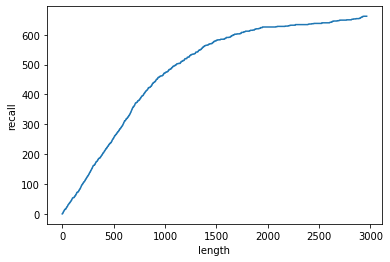

In [65]:
sns.lineplot(x="length",
               y="recall",
               data=size_rankings_df)

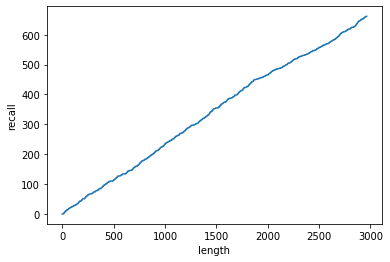

In [66]:
sns.lineplot(x="length",
               y="recall",
               data=nn_score_rankings_df)

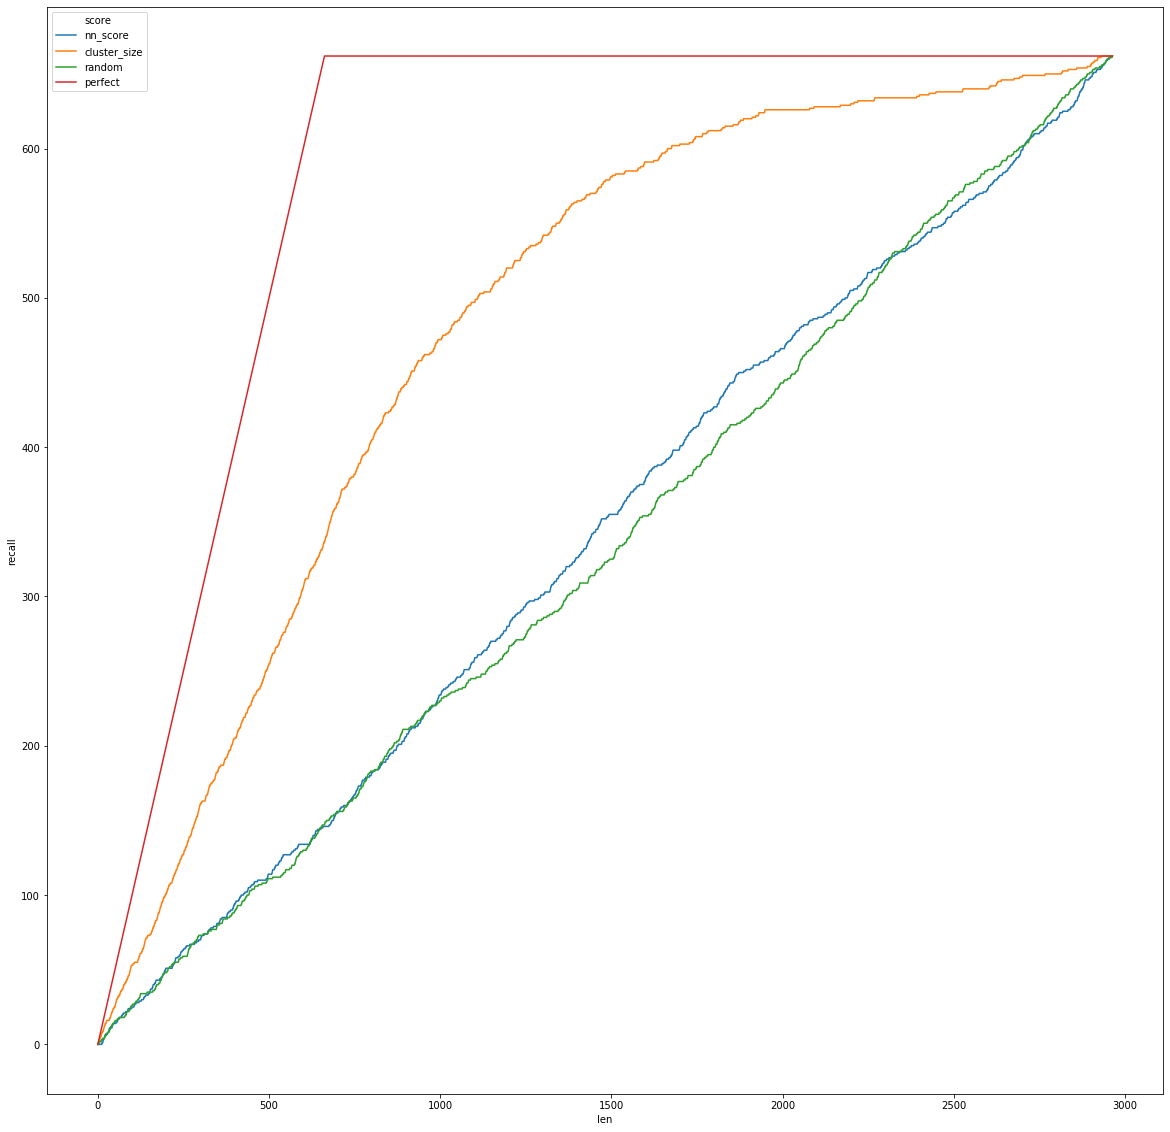

In [67]:
fix, ax = plt.subplots(figsize=(20,20))

sns.lineplot(x="len",
               y="recall",
               data=recall_length_df,
             hue="score",
            ax=ax)

In [68]:
y.shape

torch.Size([2964])

In [69]:
y_hat.shape

torch.Size([2964])

In [70]:
# Get recall and precission for different cutoffs
points = []
for cutoff in np.linspace(0, 1, 100):
    precision = get_precision(y_hat, y, cutoff)
    recall = get_recall(y_hat, y, cutoff)
    points.append({"cutoff": cutoff,
                   "precision": precision, 
                   "recall":recall,
                  "num_predicted_positives": len(y_hat[y_hat > cutoff]),
                  "num_true_positives": len(y[y_hat > cutoff][y[y_hat > cutoff] == 1])})

In [71]:
stats = pd.DataFrame(points).set_index("cutoff")

In [72]:
stats

precision    recall  num_predicted_positives  num_true_positives
cutoff                                                                    
0.000000   0.223347  1.000000                     2964                 662
0.010101   0.237661  0.945619                     2634                 626
0.020202   0.240915  0.891239                     2449                 590
0.030303   0.246028  0.865559                     2329                 573
0.040404   0.253267  0.848943                     2219                 562
...             ...       ...                      ...                 ...
0.959596   1.000000  0.000000                        0                   0
0.969697   1.000000  0.000000                        0                   0
0.979798   1.000000  0.000000                        0                   0
0.989899   1.000000  0.000000                        0                   0
1.000000   1.000000  0.000000                        0                   0

[100 rows x 4 columns]

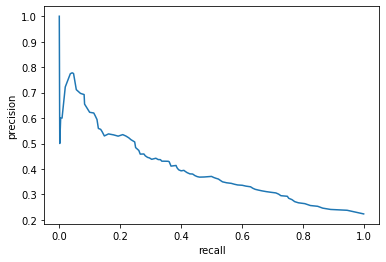

In [73]:
sns.lineplot(x="recall",
               y="precision",
               data=stats)

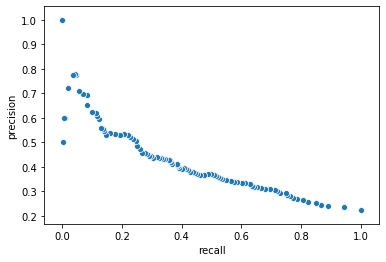

In [74]:
sns.scatterplot(x="recall",
               y="precision",
               data=stats,
            estimator=None)

In [75]:
stats.iloc[0].num_true_positives / stats.iloc[0].num_predicted_positives

0.2233468286099865

In [76]:
base_precision = len(events_test[events_test["Ligand Confidence"] == "High"]) / len(events_train)
base_precision

NameError: name 'events_train' is not defined

In [ ]:
raise Exception

# Evaluate - Train Data

In [ ]:
y_test = []
y_test_hat = []

In [ ]:
for i, data in enumerate(train_dataloader):
    # get the inputs; data is a list of [inputs, labels]
    print("Iteration: {}".format(i))
    x = data["x"]
    y = data["y"]
#     x = x.unsqueeze(1)
    y = y.view(-1,1)
    
    outputs = model(x)
    
    y_test.append(y.detach())
    y_test_hat.append(outputs.detach())
#     optimizer.zero_grad()
    gc.collect()

In [ ]:
y = torch.cat(y_test)
y_hat = torch.cat(y_test_hat)

In [ ]:
# Get recall and precission for different cutoffs
points = []
for cutoff in np.linspace(0, 1, 50):
    precision = get_precision(y_hat, y, cutoff)
    recall = get_recall(y_hat, y, cutoff)
    points.append({"cutoff": cutoff,
                   "precision": precision, 
                   "recall":recall})

In [ ]:
stats = pd.DataFrame(points).set_index("cutoff")

In [ ]:
stats

In [ ]:
sns.lineplot(x="recall",
               y="precision",
               data=stats,
            estimator=None)

In [ ]:
sns.scatterplot(x="recall",
               y="precision",
               data=stats,
            estimator=None)

In [ ]:
base_precision = len(events_train[events_train["ligand_confidence_inspect"] == "High"]) / len(events_train)
base_precision

In [ ]:
while True:
    time.sleep(60)

In [ ]:
torch.save(model.state_dict(), "model_params.pt")

# Inspect Model

In [ ]:
trace.history

In [ ]:
iterator = dataset.make_one_shot_iterator()

In [ ]:
x, y = iterator.next()

In [ ]:
x

In [ ]:
model.net(x)

In [ ]:
print(y)

In [ ]:
model.save_weights("model_32.h5")

In [ ]:
from torch.ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator

In [ ]:
trainer = create_supervised_trainer(model, optimizer, loss)

In [ ]:
@trainer.on(Events.EPOCH_COMPLETED)
def print